In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import json
import pandas as pd
# Load JSON data from a file into a dictionary
df = pd.read_csv("results/csv/vnexpress_thegioi_24_6.csv")
df = df.fillna("")
# Display the dictionary

In [3]:
data = df.to_dict('records')

In [ ]:
from backend.extractor.task.llm_downstream_utils import get_summarize_prompt, llm_get_tags

# Word Cloud

In [21]:
data

[{'title': 'Hơn 50 người Ấn Độ chết vì ngộ độc rượu',
  'description': 'Giới chức bang Tamil Nadu ở miền nam Ấn Độ thông báo 53 người chết vì uống rượu pha cồn công nghiệp methanol, một loại chất độc.',
  'article': 'Vụ ngộ độc xảy ra ngày 18/6 khiến hơn 100 người phải nhập viện, song nhiều nạn nhân trong tình trạng nguy kịch đến mức các bác sĩ không thể cứu chữa. Muthuvel Stalin, thủ hiến bang Tamil Nadu, cho biết 37 người thiệt mạng vài giờ sau khi uống rượu pha cồn công nghiệp methanol. M.S. Prasanth, quan chức cấp cao tại quận Kallakurichi thuộc bang Tamil Nadu, ngày 22/6 thông báo 53 người chết trong vụ ngộ độc, 7 người liên quan đã bị bắt. Truyền thông Ấn Độ ngày 23/6 đưa tin 56 người đã tử vong, song giới chức nước này chưa bình luận về thông tin. Theo ủy viên hội đồng địa phương Palraj, những người lao động nghèo ở quận Kallakurichi thường mua những túi rượu giá 60 rupee (0,7 USD) để uống trước khi đi làm. Trong vụ ngộ độc ngày 18/6, một số người bị mù và được đưa tới bệnh viện

/Users/minhphan/anaconda3/envs/thesis-3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-29 14:32:54,953 - llm_utils.py: prepare_word_cloud(): 164:	Preprocessing data
--------
2024-06-29 14:32:56,896 - nlp_tasks.py: create_word_cloud(): 31:	done prepare
--------
2024-06-29 14:32:56,896 - llm_utils.py: draw_word_cloud(): 115:	Generating word cloud
--------
2024-06-29 14:32:57,154 - llm_utils.py: draw_word_cloud(): 135:	Drawn word cloud
--------


'results/word_cloud/wordcloud_d5a4e9fa-b109-4a21-a27c-158d8ad6d936.png'

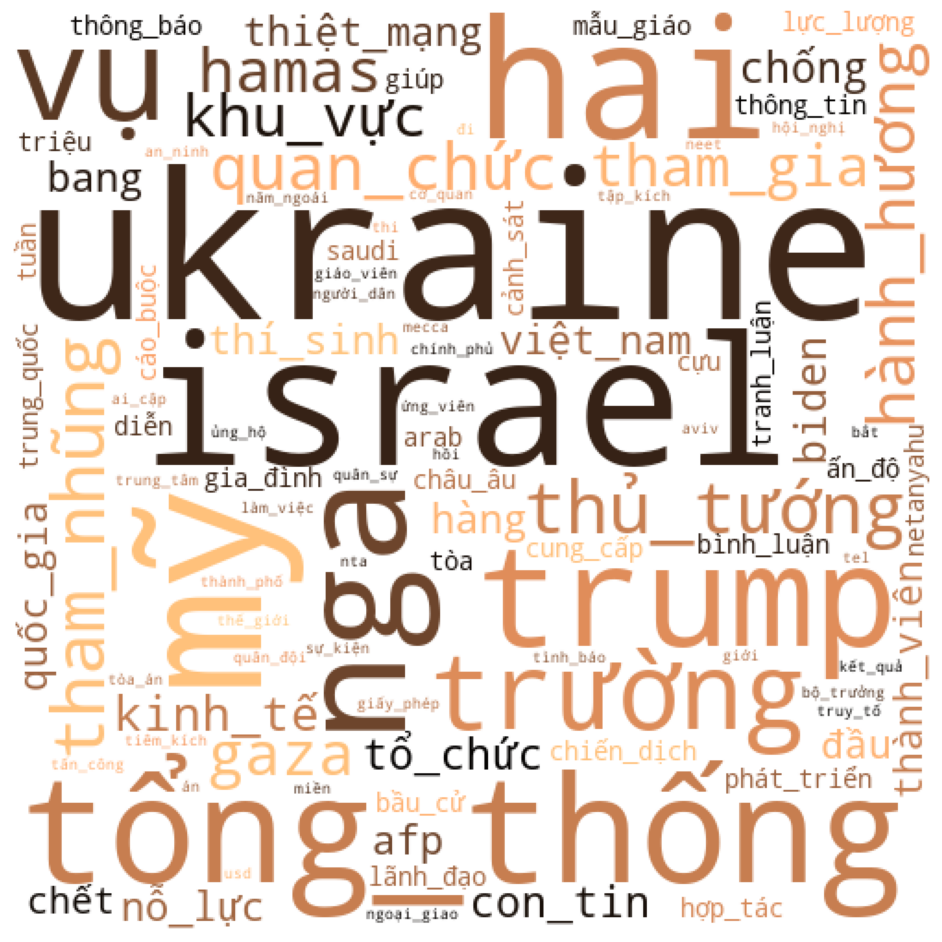

In [4]:
# corpus, stopwords = prepare_word_cloud(data, selected_columns=["article"], fixed_words=["giáo dục và đào tạo", "đại học quốc gia hà nội", "đại học quốc gia tphcm", "đhqg tphcm", "đại học qg tp hcm", "đại học quốc gia tphcm", "phổ thông năng khiếu"])
from backend.extractor.task.nlp_tasks import create_word_cloud

create_word_cloud(
    data, colormap="copper", selected_columns=["article"], regex_patterns=[], fixed_words=[], save=True, max_words=100,
)

# LLM Classify

In [4]:
from backend.extractor.task.llm_utils import llm_extract_task

/Users/minhphan/anaconda3/envs/thesis-3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'mentions': '', 'tags': ''}

In [52]:
import asyncio
from time import time
from backend.llm.utils import parse_llm_response_data
from backend.logger import get_logger
from backend.llm.llm import LLM
from backend.extractor.task.llm_utils import llm_task


logger = get_logger()
tasks = f"""{{
             "tags": "List 2 - 4 news categories that this article might belong to, separate each categories by a comma, remove list [] and string ' ' syntax"
             "mentions": "List all name of people, subjects, organizations, that the text mentions in keywords, remove list [] and string ' ' syntax",
             }}"""


def get_task_dict(task):
    if isinstance(task, dict):
        task_dict = task
    else:
        task_dict = json.loads(task)
    res = {}
    for key in task_dict.keys():
        res[key] = ""
    return res


# async def llm_extract_task(data, llm_task_format, columns=None, batch_size=12, delay=65):
#     to_classify = []
#     logger.info("Getting texts")
#     if len(columns) == 0:
#         selected_columns = list(data[0].keys())
#     else: selected_columns = columns

#     for row in data:
#         text = "\n".join(value for key, value in row.items() if key in selected_columns)
#         to_classify.append(text)

#     def chunks(data, batch_size):
#         for i in range(0, len(data), batch_size):
#             yield data[i : i + batch_size]

#     batches = list(chunks(to_classify, batch_size))
#     print(batches)
#     responses = []
#     for i, batch in enumerate(batches):
#         logger.info(f"Processing batch number: {i + 1}")
#         tasks = [llm_task(text, llm_task_format) for text in batch]
#         try:
#             batch_responses = await asyncio.gather(*tasks, return_exceptions=True)
#             for response in batch_responses:
#                 if isinstance(response, Exception):
#                     print("Successful response")
#                     responses.append(response)
#                     print(response)
#                 else:
#                     print(response)
#                     responses.append(response)
#         except Exception as e:
#             print(f"Error processing batch number: {i + 1}, Error: {e}")
#             # If the whole batch fails, add empty responses for the entire batch
#             # responses.extend([get_task_dict(llm_task_format) for _ in batch])
#         finally:
#             if i < len(batches) - 1:
#                 await asyncio.sleep(delay)
#     return responses

# llm_responses = await llm_extract_task(data[0:3], tasks, columns=["article"], batch_size=10)

In [12]:
type(llm_responses[0]["tags"])

str

In [9]:
def combine_res(data, responses, tasks):
    for record, response in zip(data, responses):
        if isinstance(response, dict):
            record.update(response)
        else:
            record.update(get_task_dict(tasks))

    return data

In [60]:
def combine_res(data, responses, tasks):
    for record, response in zip(data, responses):
        if isinstance(response, dict):
            record.update(response)
        else:
            record.update(get_task_dict(tasks))

        return data


def get_task_dict(task):
    res = {}
    for key in task.keys():
        res[key] = ""
    return res


async def llm_classify_task(data, tasks, columns):
    data.fillna("")
    dictionaries = data.to_dict("records")
    selected_columns = columns.split(",")
    selected_columns = (
        [col.strip() for col in selected_columns] if columns != "" else []
    )
    print(selected_columns)
    responses = await llm_extract_task(dictionaries, tasks, columns)
    result = combine_res(dictionaries, responses, tasks)
    df = pd.DataFrame(result)
    return df
tasks = {"tags": "List 2 - 4 news categories that this article might belong to, separate each categories by a comma, remove list [] and string ' ' syntax",
         "mentions": "List all name of people, subjects, organizations, that the text mentions in keywords, remove list [] and string ' ' syntax"}
result_df = await llm_classify_task(pd.read_csv("results/csv/vnexpress_thegioi_24_6.csv")[0:3], tasks, columns="description")

2024-06-29 16:00:11,714 - llm_utils.py: llm_extract_task(): 77:	Getting texts
--------
2024-06-29 16:00:11,714 - llm_utils.py: llm_extract_task(): 96:	Processing batch number: 1
--------


['description']
[['Giới chức bang Tamil Nadu ở miền nam Ấn Độ thông báo 53 người chết vì uống rượu pha cồn công nghiệp methanol, một loại chất độc.', 'Phán quyết "có tội" ở New York sẽ khiến các vụ truy tố còn lại của ông Trump trở nên phức tạp hơn, nhưng ông nhiều khả năng không bị xét xử thêm trước ngày bầu cử.', 'Bất đồng liên quan gói vũ khí viện trợ của Mỹ cho Israel khiến Tel Aviv và Washington chỉ trích lẫn nhau, gia tăng rạn nứt giữa hai đồng minh.']]
{'tags': 'Tin tức, Thế giới, Ấn Độ, Sức khỏe', 'mentions': 'Tamil Nadu, Ấn Độ, methanol'}
{'tags': 'Luật pháp, Chính trị, Bầu cử, Hoa Kỳ', 'mentions': 'Donald Trump, New York'}
{'tags': 'Chính trị quốc tế, Quan hệ quốc tế, Quân sự, Ngoại giao', 'mentions': 'Mỹ, Israel, Tel Aviv, Washington'}


In [61]:
result_df

,title,description,article,date,topic,tags,mentions
0,Hơn 50 người Ấn Độ chết vì ngộ độc rượu,Giới chức bang Tamil Nadu ở miền nam Ấn Độ thô...,Vụ ngộ độc xảy ra ngày 18/6 khiến hơn 100 ngườ...,"Chủ nhật, 23/6/2024, 20:30 (GMT+7)",NaN,"Tin tức, Thế giới, Ấn Độ, Sức khỏe","Tamil Nadu, Ấn Độ, methanol"
1,Tương lai ba vụ truy tố ông Trump sau phán quy...,"Phán quyết ""có tội"" ở New York sẽ khiến các vụ...","Vài tháng trước, nhiều người nghĩ rằng cựu tổn...","Chủ nhật, 23/6/2024, 19:00 (GMT+7)",Ông Trump bị truy tố ở New York Kết tội Phiên ...,NaN,NaN
2,Bất đồng về vũ khí khoét sâu rạn nứt Mỹ - Israel,Bất đồng liên quan gói vũ khí viện trợ của Mỹ ...,Thủ tướng Israel Benjamin Netanyahu trong vide...,"Thứ hai, 24/6/2024, 00:00 (GMT+7)",NaN,NaN,NaN


[{'title': 'Hơn 50 người Ấn Độ chết vì ngộ độc rượu',
  'description': 'Giới chức bang Tamil Nadu ở miền nam Ấn Độ thông báo 53 người chết vì uống rượu pha cồn công nghiệp methanol, một loại chất độc.',
  'article': 'Vụ ngộ độc xảy ra ngày 18/6 khiến hơn 100 người phải nhập viện, song nhiều nạn nhân trong tình trạng nguy kịch đến mức các bác sĩ không thể cứu chữa. Muthuvel Stalin, thủ hiến bang Tamil Nadu, cho biết 37 người thiệt mạng vài giờ sau khi uống rượu pha cồn công nghiệp methanol. M.S. Prasanth, quan chức cấp cao tại quận Kallakurichi thuộc bang Tamil Nadu, ngày 22/6 thông báo 53 người chết trong vụ ngộ độc, 7 người liên quan đã bị bắt. Truyền thông Ấn Độ ngày 23/6 đưa tin 56 người đã tử vong, song giới chức nước này chưa bình luận về thông tin. Theo ủy viên hội đồng địa phương Palraj, những người lao động nghèo ở quận Kallakurichi thường mua những túi rượu giá 60 rupee (0,7 USD) để uống trước khi đi làm. Trong vụ ngộ độc ngày 18/6, một số người bị mù và được đưa tới bệnh viện

In [14]:
type(data)

list

In [10]:
from backend.extractor.utils import save_crawled_data_to_csv


save_crawled_data_to_csv(data, "results/csv/vnexpress_thegioi_24_6_CLASSIFIED.csv")

In [12]:
response

{'mentions': '["NEET-UG", "Ấn Độ", "NTA", "Dharmendra Pradhan", "S. V. Bhatti", "Narendra Modi", "Mallikarjun Kharge", "INC", "Surbhi Sharma", "Vivek Pandey", "Bihar", "Manavjit Singh Dhillon", "BJP", "Godhra", "Rajasthan", "Delhi"]',
 'tags': '["Giáo dục", "Kỳ thi", "Ấn Độ", "Y tế", "Lộ đề", "Gian lận", "Tòa án", "Điều tra", "Bất thường", "Cáo buộc", "Phản đối", "Chính trị"]'}